## **Project** **Title**: **Gas** **Power** **Generation** **Forecasting** **Using** **XGBoost** **and** **LSTM**

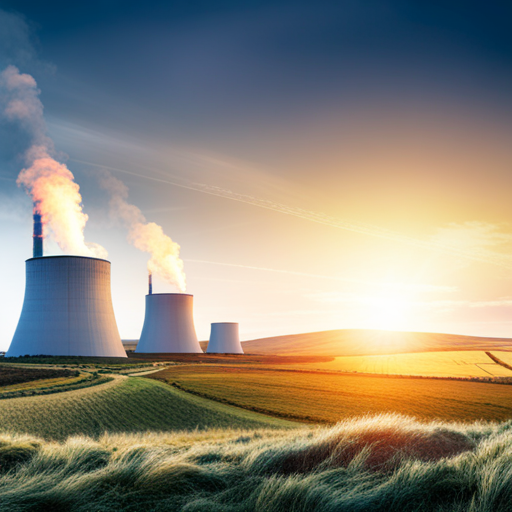

Power generation from gas is a significant source of NO2 and PM emissions in the UK. As the UK's energy mix becomes more reliant on renewable energy sources, the need for accurate gas generation forecasting is more important than ever. The sporadic nature of renewable energy sources mean that they do not always produce electricity when it is needed. Gas power plants are used to balance the grid and ensure that there is always enough electricity available to meet demand.

Accurate gas generation forecasting also helps to ensure that gas power plants are only used when necessary, reducing the amount of greenhouse gases emitted from the gas plants. It also helps to improve grid reliability, by knowing how much gas power will be available in the future, grid operators can make better decisions about how to manage the grid as well as reduce costs.

This project aims to explore time series forecasting of gas power generation in the UK, using two different methods:

**1)** **XGBoost** -

eXtreme Gradient Boosting is a machine learning algorithm following the gradient boosting framework, where weak learners (decision trees) are sequentially trained to correct the mistakes made by the previous models. This iterative process helps improve the overall model performance.

It takes in the following general parameters:

> a. boosters: 'gbtree' for tree-based model or 'gblinear for linear models

> b. n_estimators: The number of boosting rounds(i.e., the number of trees to build)

> c. learning rate: The learning rate or shrinkage factor, which controls the impact of each tree on the final prediction

> d. max_depth: The maximum depth of a tree. It controls the complexity of the tree and helps prevent overfitting

> e. early_stopping_rounds : The number of rounds without improvement in evaluation metric to trigger early stopping

> f. objective: The objective function to optimise during training, such as "reg:linear" for regression or "binary:logistic" for binary classification.

 XGBoost is used to forecast a period of two weeks of hourly gas production.








**2)** **LSTM** -

LSTM stands for long short term memory. It is a model or architecture that extends the memory of recurrent neural networks(RNN). Typically, recurrent neural networks have ‘short term memory’ in that they use persistent previous information to be used in the current neural network. Essentially, the previous information is used in the present task.
They can capture long-term dependencies in the input sequence and make predictions based on the learned patterns.

Here, LSTM has been used to forecast a one-day period of hourly gas production.

### Loading the Data

To accomplish this, data has been extracted from the [Modo Energy Platform](https://https://platform.modo.energy/data?sections=Grid)

Our data shows the total power generated by gas in MWs by both CCGT(Combined Cycle Gas Turbine) and OCGT(Open Cycle Gas Turbine) in UK for the time period 24th Jun 22' to 25th Jun 23'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
gas = pd.read_csv('energy_generation_gas.csv')

In [3]:
gas.head()

,Hour,Gas(MWs)
0,2022-06-24T00:00:00+0100,15892
1,2022-06-24T01:00:00+0100,15267
2,2022-06-24T02:00:00+0100,15966
3,2022-06-24T03:00:00+0100,15882
4,2022-06-24T04:00:00+0100,16187


### Data Pre Processing
Creating a function to convert the Timestamp column to datetime format

In [4]:
from datetime import datetime

def convert_hour(row):
    Hour = row['Hour']
    datetime_obj = datetime.strptime(Hour, "%Y-%m-%dT%H:%M:%S%z")
    formatted_datetime = datetime_obj.strftime("%Y-%m-%d %H:%M")
    return formatted_datetime

# Applying the function to our dataset
gas['Hour'] = gas.apply(convert_hour, axis=1)

In [5]:
gas.head()

,Hour,Gas(MWs)
0,2022-06-24 00:00,15892
1,2022-06-24 01:00,15267
2,2022-06-24 02:00,15966
3,2022-06-24 03:00,15882
4,2022-06-24 04:00,16187


In [48]:
# Checking for null values
gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8806 entries, 2022-06-24 00:00:00 to 2023-06-25 23:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Gas(MWs)  8806 non-null   int64
dtypes: int64(1)
memory usage: 395.6 KB


In [7]:
gas.describe()

,Gas(MWs)
count,8806.000000
mean,11850.565069
std,5457.684926
min,0.000000
25%,7416.250000
50%,12191.000000
75%,15904.750000
max,25633.000000


Converting the Timestamp column to index

In [8]:
gas['Hour'] = pd.to_datetime(gas['Hour'])
gas.set_index('Hour', inplace=True)

In [9]:
gas.head()

,Gas(MWs)
Hour,
2022-06-24 00:00:00,15892
2022-06-24 01:00:00,15267
2022-06-24 02:00:00,15966
2022-06-24 03:00:00,15882
2022-06-24 04:00:00,16187


Visualising the Data


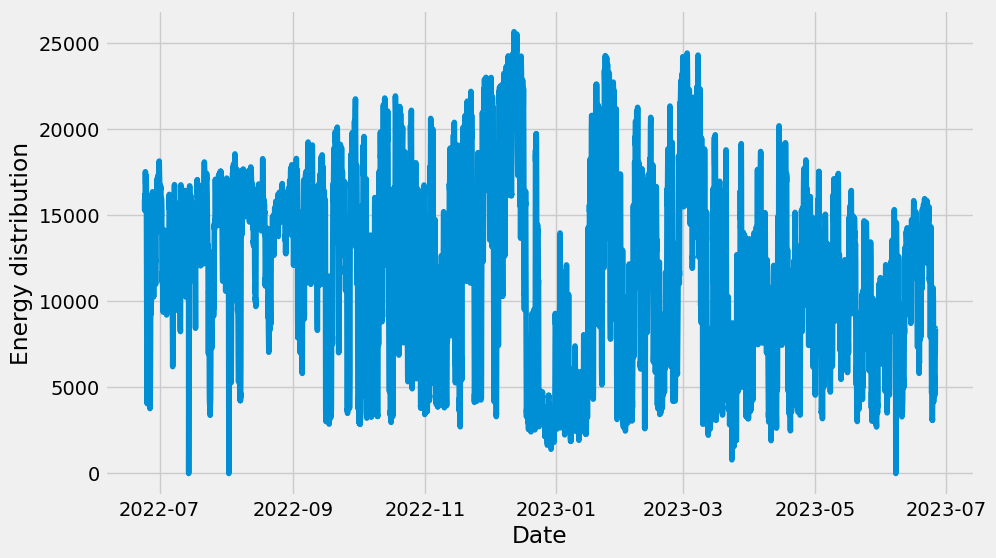

In [10]:
plt.xlabel("Date")
plt.ylabel("Energy distribution")
plt.plot(gas)

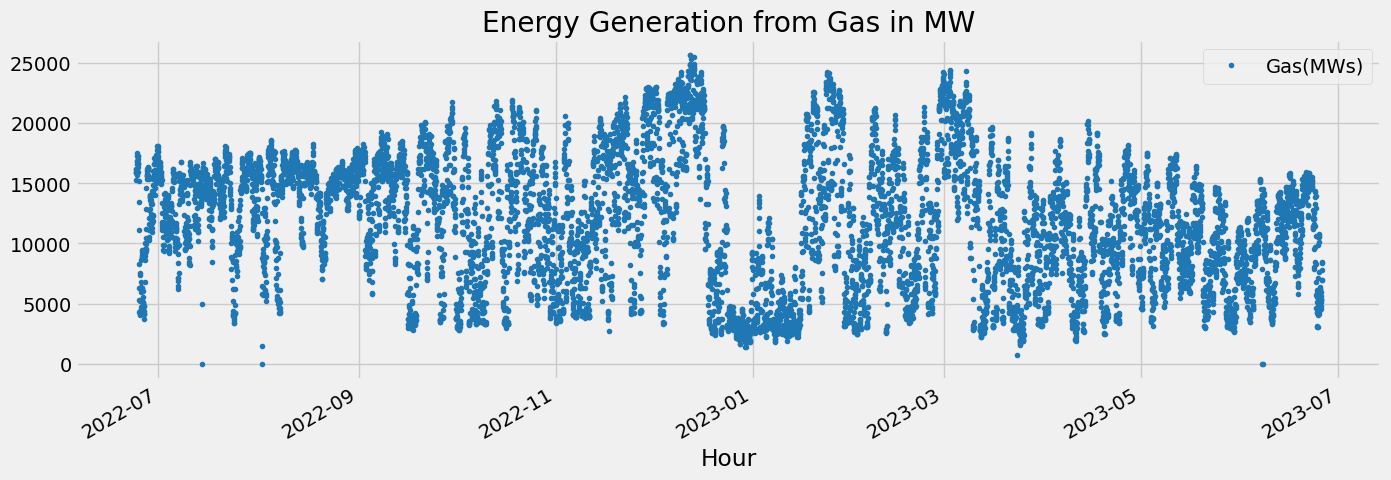

In [11]:
gas.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy Generation from Gas in MW')
plt.show()

### Time Series Feature Creation

Feature engineering in time series data requires capturing temporal patterns and dependancies that can affect the target variable.

Here we will create the features like date, hour, day of week, weekday, quarter, month, year, day of year, week of year and season which can explain the trends of gas powergeneration data

In [12]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )

    return df

Gas = create_features(gas)

<ipython-input-12-fcf6424fbeb8>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


Visualising the Target/ Feature relationship

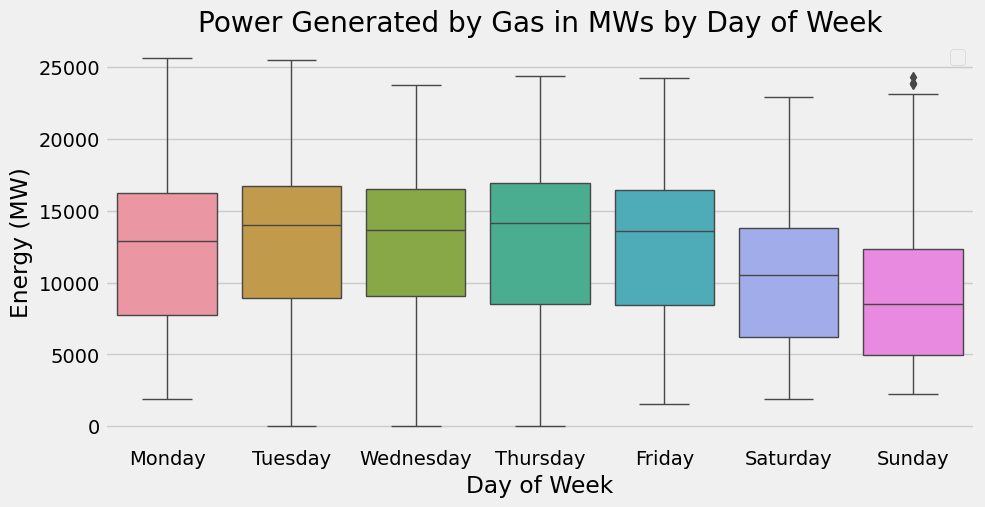

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Gas,
            x='weekday',
            y='Gas(MWs)',
           # hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Generated by Gas in MWs by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

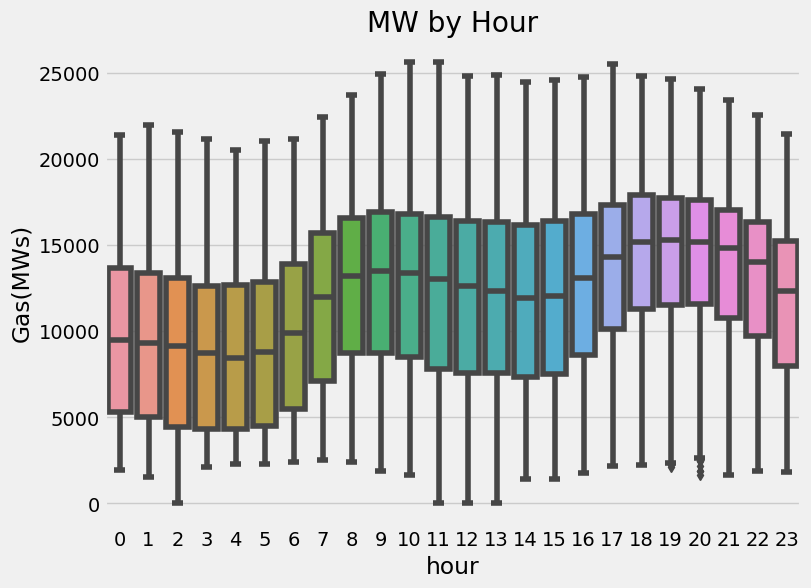

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=Gas, x='hour', y='Gas(MWs)')
ax.set_title('MW by Hour')
plt.show()

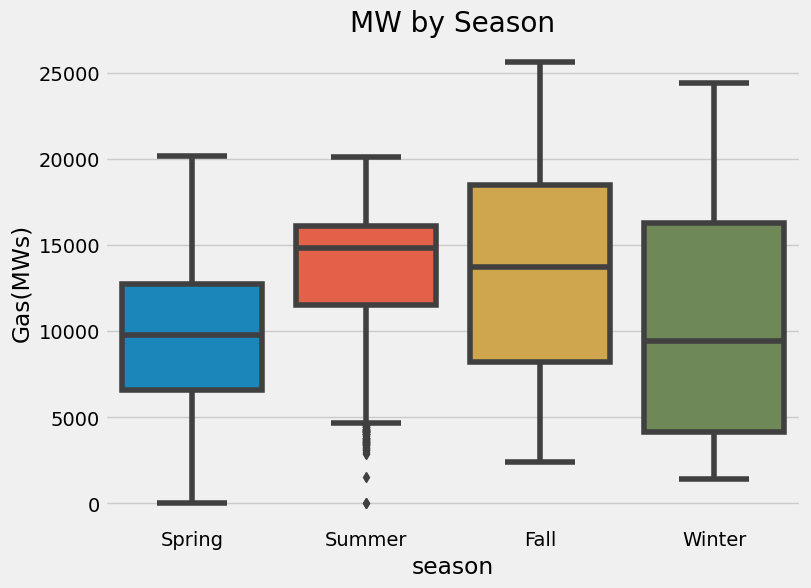

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=Gas, x='season', y='Gas(MWs)')
ax.set_title('MW by Season')
plt.show()

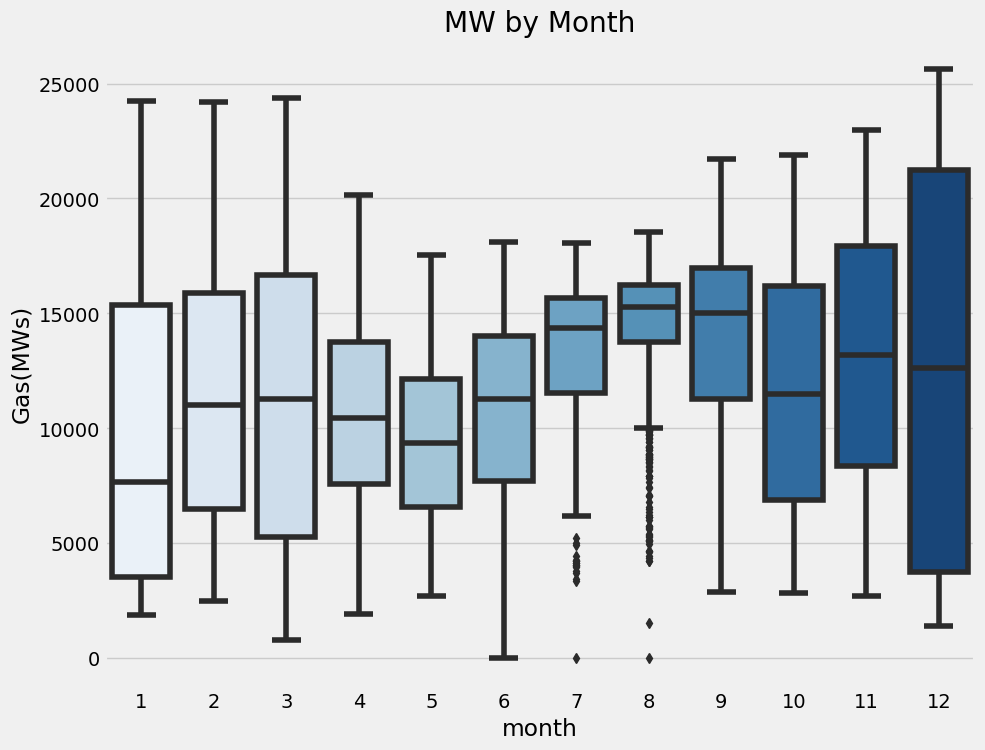

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=Gas, x='month', y='Gas(MWs)', palette='Blues')
ax.set_title('MW by Month')
plt.show()

### Feature Importance

These features play a significant role in predicting or explaining the variations in gas power generation. In our data we can see the following features as the most important:

1) **Day of Year**: The high feature importance of this variable suggests that the gas power generation shoots up significantly on certain days in the year. Since Gas power generation often plays a role in balancing the grid, this feature reflects issues like the fluctuating supply of renewables, weather conditions, gas pricing and maintenance scheduling.  

2) **Hour**: The feature importance of hour suggests that the gas power generation varies significantly throughout the day. In UK, on average, the highest gas power generation occurs in the evening between 6 to 8 PM while the lowest occurs early in the morning, around 4 am.

3) **Day of the Week**: The feature importance of the day of week shows that power generation from gas is higher on weekdays than on weekends. For UK, on average more power is generated from gas on a Thursday on given week than any other day. While, power generated from gas on Sunday is significantly lower than any other day of the week.

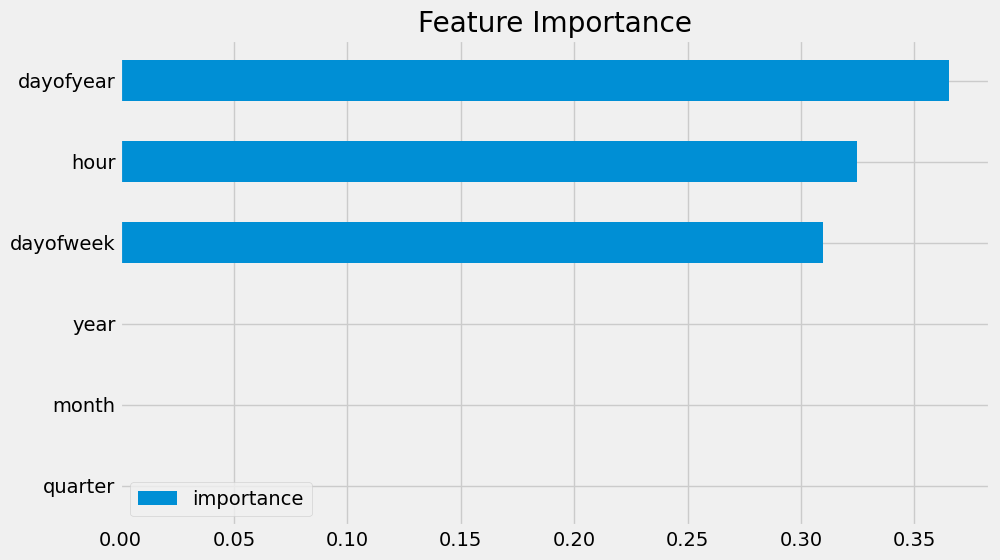

In [20]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Splitting the training and testing data to forecast gas power generation for a period of two weeks : 12th June 2023 to 25th June 2023

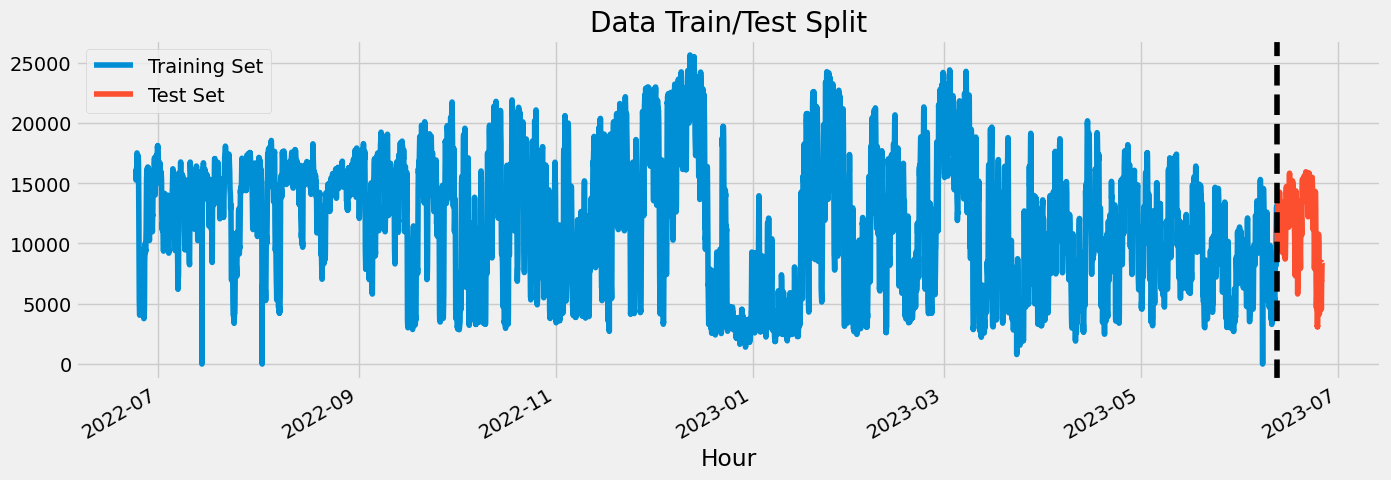

In [17]:
train = gas.loc[gas.index < '06-12-2023']
test = gas.loc[gas.index >= '06-12-2023']

# Visualising the plot to see where the data splits off from testing to training
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('06-12-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Creating the Model

In [18]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Gas(MWs)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

<ipython-input-12-fcf6424fbeb8>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-12-fcf6424fbeb8>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


### Running the regression using XGBoost

For the task of time series forecasting of power generated by Gas for the period of 6th Jun 23' to 24th Jun 23' from the training dataset of hourly energy generated by gas from  the period of 24th Jun 22' to 6th Jun 23', XGBoost is used with a learning rate of 0.05(which was found to be the most optimal) and a maximum depth of 3.

In [19]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.05)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[14:58:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:12514.35693	validation_1-rmse:11587.02240
[100]	validation_0-rmse:3388.77723	validation_1-rmse:2834.30238
[200]	validation_0-rmse:2886.64220	validation_1-rmse:2698.03668
[300]	validation_0-rmse:2592.72051	validation_1-rmse:2456.34296
[400]	validation_0-rmse:2339.14830	validation_1-rmse:2390.93548
[500]	validation_0-rmse:2171.08117	validation_1-rmse:2331.65613
[600]	validation_0-rmse:2042.46201	validation_1-rmse:2310.98656
[700]	validation_0-rmse:1932.40825	validation_1-rmse:2294.63133
[793]	validation_0-rmse:1852.75182	validation_1-rmse:2354.94777


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### Forecasting on the test dataset

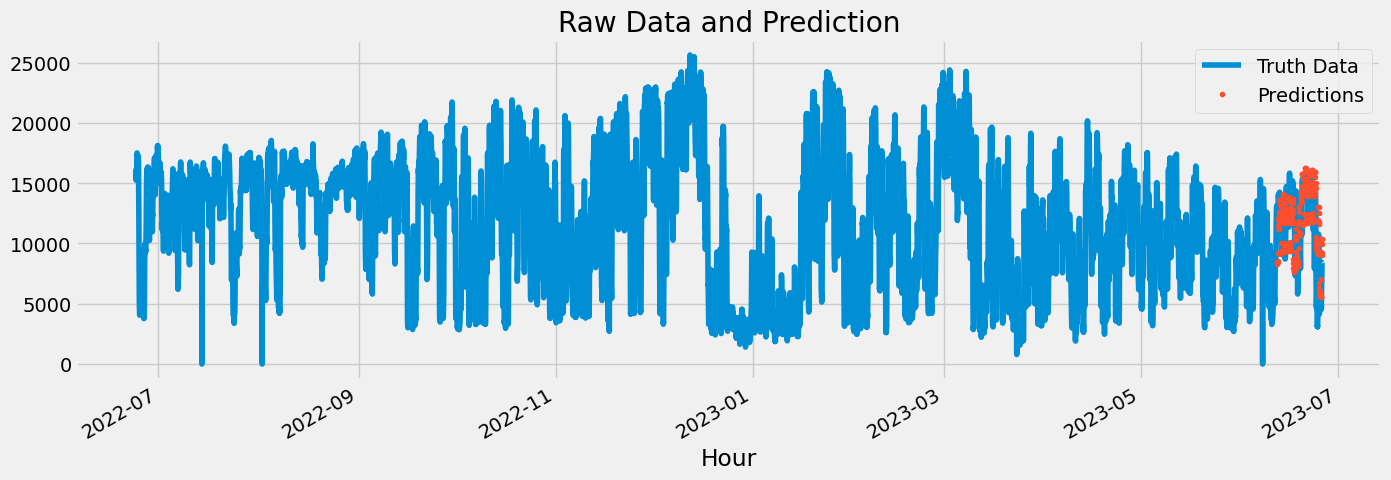

In [21]:
test['prediction'] = reg.predict(X_test)
Gas = Gas.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = Gas[['Gas(MWs)']].plot(figsize=(15, 5))
Gas['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

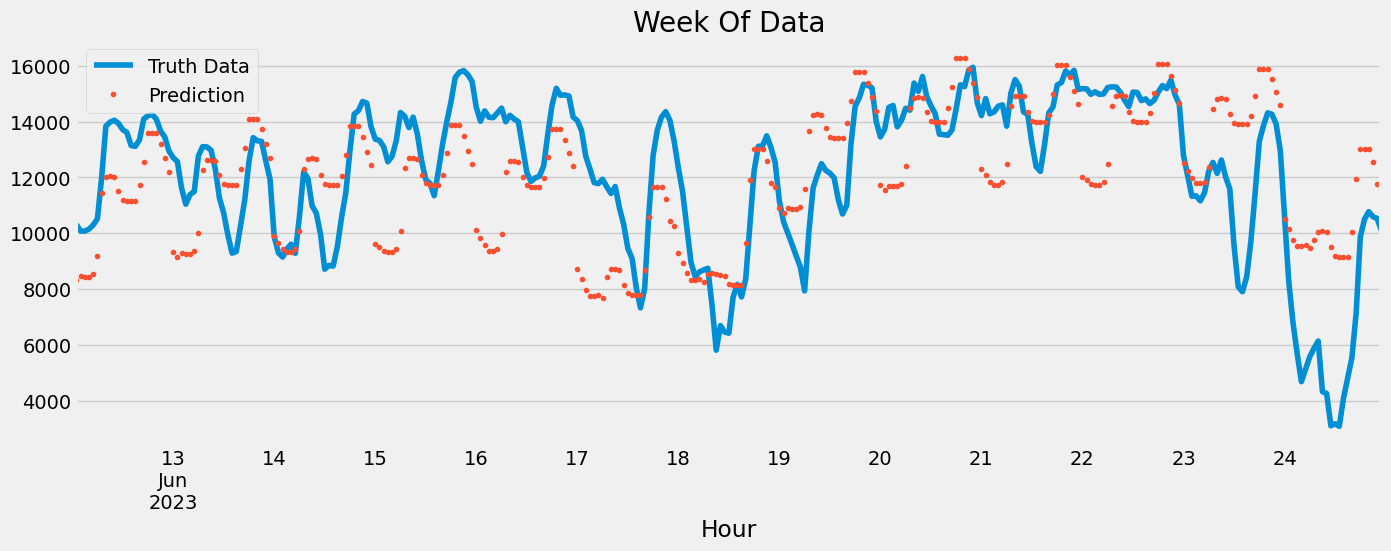

In [46]:
ax = gas.loc[(Gas.index > '06-12-2023') & (Gas.index < '06-25-2023')]['Gas(MWs)'].plot(figsize=(15, 5), title='Week Of Data')
Gas.loc[(Gas.index > '06-12-2023') & (Gas.index < '06-25-2023')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

### Calculating Error
Score(RMSE)

In [23]:
score = np.sqrt(mean_squared_error(test['Gas(MWs)'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2289.82


Looking at the worst and best predicted days

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-06-24    3794.490112
2023-06-17    2727.395426
2023-06-23    2287.376099
2023-06-16    2138.715617
2023-06-15    1988.143433
2023-06-19    1557.618001
2023-06-12    1553.702230
2023-06-13    1548.196167
2023-06-25    1311.879964
2023-06-22    1284.125285
Name: error, dtype: float64

##### 22nd Jun 23' was the best predicted day while 24th Jun 23' was the worst predicted day from this model.

## LSTMs

We start with importing the libraries required for LSTMs


In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Splitting the data
train = gas.loc[gas.index < '06-25-2023']
test = gas.loc[gas.index >= '06-25-2023']

### Pre processing using MinMax Scaler
We will use the MinMax Scaler to convert the data points for gas power generation into a scale of 0 to 1.

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [28]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#### Creating a Time Series Generator Object

In [29]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 24
n_features= 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

#### Using Tensorflow backend

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#### Defining the Model

In [31]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit_generator(generator,epochs=15)

Epoch 1/15
8758/8758 [==============================] - 160s 18ms/step - loss: 0.0037
Epoch 2/15
8758/8758 [==============================] - 140s 16ms/step - loss: 0.0017
Epoch 3/15
8758/8758 [==============================] - 124s 14ms/step - loss: 0.0015
Epoch 4/15
8758/8758 [==============================] - 138s 16ms/step - loss: 0.0014
Epoch 5/15
8758/8758 [==============================] - 122s 14ms/step - loss: 0.0014
Epoch 6/15
8758/8758 [==============================] - 118s 14ms/step - loss: 0.0013
Epoch 7/15
8758/8758 [==============================] - 119s 14ms/step - loss: 0.0013
Epoch 8/15
8758/8758 [==============================] - 125s 14ms/step - loss: 0.0012
Epoch 9/15
8758/8758 [==============================] - 129s 15ms/step - loss: 0.0012
Epoch 10/15
8758/8758 [==============================] - 124s 14ms/step - loss: 0.0012
Epoch 11/15
8758/8758 [==============================] - 133s 15ms/step - loss: 0.0012
Epoch 12/15
8758/8758 [=============================

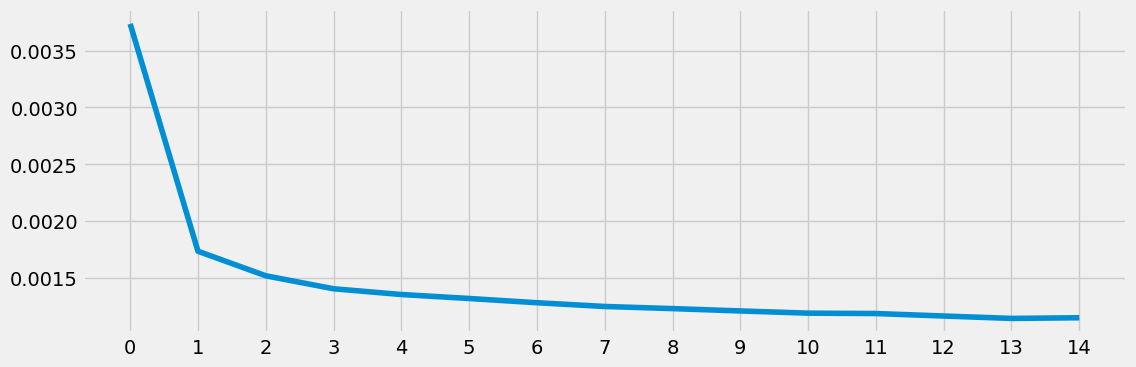

In [33]:
loss_per_epoch = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

Using the last 24 values from the training dataset and reshaping it in the model.

In [34]:
last_train_batch = scaled_train[-24:]

In [35]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

Predicting the first value from the test dataset for 24th June 2023

In [36]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 239ms/step


array([[0.3362093]], dtype=float32)

Checking the actual value from the scaled test dataset

In [37]:
scaled_test[0]

array([0.29934069])

Now doing the same for predicting all the values

In [38]:
# Creating an empty list for test predictions
test_predictions = []

# Creating batches consisting of the last 24 values and reshaping each batch for each prediction
batch = scaled_train[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


Transforming the scaled values back into the range for MWs

In [40]:
true_predictions = scaler.inverse_transform(test_predictions)

In [41]:
test['Predictions'] = true_predictions

In [43]:
test

,Gas(MWs),Predictions
Hour,,
2023-06-25 00:00:00,7673,8618.052915
2023-06-25 01:00:00,5928,7192.730860
2023-06-25 02:00:00,4147,6240.771738
2023-06-25 03:00:00,4317,5846.024877
2023-06-25 04:00:00,4675,5923.449994
2023-06-25 05:00:00,5222,6384.020274
2023-06-25 06:00:00,6390,7046.891097
2023-06-25 07:00:00,6201,7743.401648
2023-06-25 08:00:00,6235,8314.712106


Visualising the predictions given by LSTMs against the test dataset values for the 25th of June 2023.

<Axes: xlabel='Hour'>

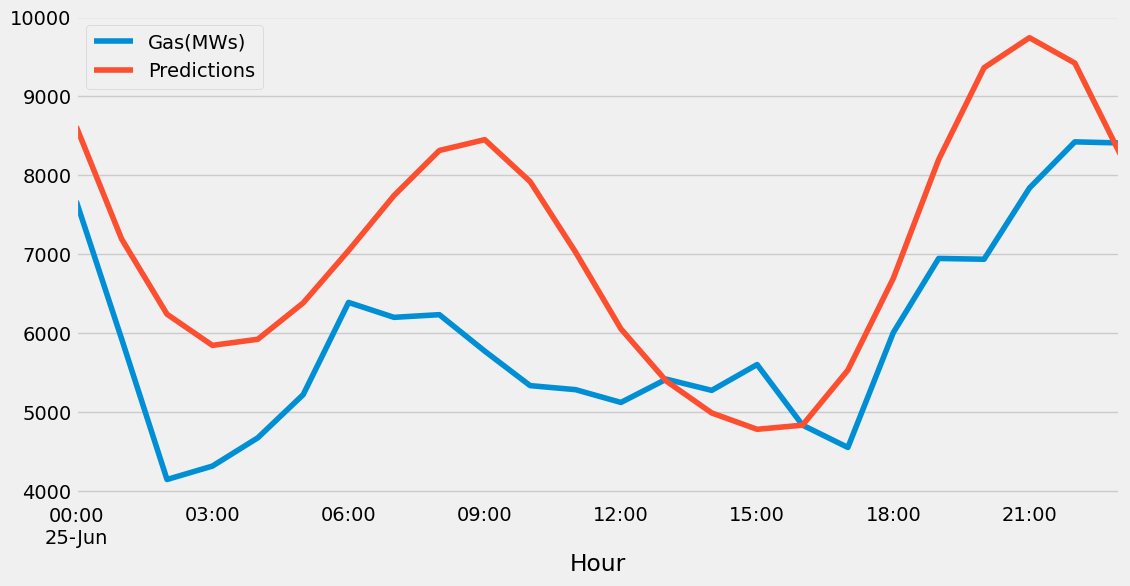

In [42]:
test.plot(figsize=(12,6))

Score(RMSE)

In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Gas(MWs)'],test['Predictions']))
print(rmse)

1462.104591739849


## Conclusion

This project concludes:

 1) Comparing the RMSEs, LSTM was a more accurate predictor for gas production for a one-day hourly period, but with this data for hourly frequency, it was unable to accurately predict a longer period of 2 weeks. (Neural networks are definitely a challenge for me, and I'm pretty sure there is some intricacy that I might've looked over).



 2) XGBoost had a higher RMSE, but did a better job at predicting a longer period of forecast.


 3) We understood that the three most important features affecting gas production are:

  

> **Day of the year** : Since gas often plays a role in balancing the grid, this feature reflects issues like the fluctuating supply of renewables, weather conditions, gas pricing and maintenance scheduling.

> **Hour** : In the UK, on average, the highest gas power generation occurs in the evening between 6 to 8 PM while the lowest occurs early in the morning, around 4 am.

> **Day of week** : Power from gas generation is on average, higher on weekdays than on weekends with Thursday being the highest and Sunday being the lowest.

Future work in this project can consist of:

1) Improve accuracy for both XGBoost and Long Term Short Memory (LSTM) models

2) Exploring more time series models like ARIMA, ANNs, Phophet etc for gas production forecasts.

3) Expanding the dataset to include historical data from previous years.

4) Combining LSTM with XGBoost regressor for enhanced time series forecasting